In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Reading Data

In [218]:
df=pd.read_csv('data/data.csv')

# Exploratory Data Analysis

In [219]:

df.head()

,hydrogen_ppm,resistance_ohm,humidity_ppmv,temperature_celsius,pressure_mbar,operator,time_s
0,0.08,4.93,32497,15.04,999.98,B,1.0
1,0.17,4.51,37503,34.98,1000.00,A,2.0
2,0.00,4.52,37492,34.95,1000.02,A,3.0
3,0.04,4.85,37504,14.86,1000.00,A,4.0
4,0.00,5.06,27504,19.96,1000.01,A,5.0


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hydrogen_ppm         1500 non-null   float64
 1   resistance_ohm       1500 non-null   float64
 2   humidity_ppmv        1500 non-null   int64  
 3   temperature_celsius  1500 non-null   float64
 4   pressure_mbar        1500 non-null   float64
 5   operator             1500 non-null   object 
 6   time_s               1500 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 82.2+ KB


In [221]:
df.describe()

,hydrogen_ppm,resistance_ohm,humidity_ppmv,temperature_celsius,pressure_mbar,time_s
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,35.095567,4.040080,31249.499333,24.998073,1000.000040,1097.924000
std,22.951406,0.349281,4270.852255,7.074606,0.011487,659.300758
min,0.000000,3.520000,24988.000000,14.700000,999.960000,1.000000
25%,19.737500,3.810000,27500.000000,19.930000,999.990000,573.750000
50%,39.810000,3.950000,31251.000000,24.990000,1000.000000,1146.500000
75%,59.775000,4.130000,34999.000000,30.070000,1000.010000,1719.250000
max,70.280000,5.240000,37514.000000,35.320000,1000.040000,2193.000000


## Data Distribution

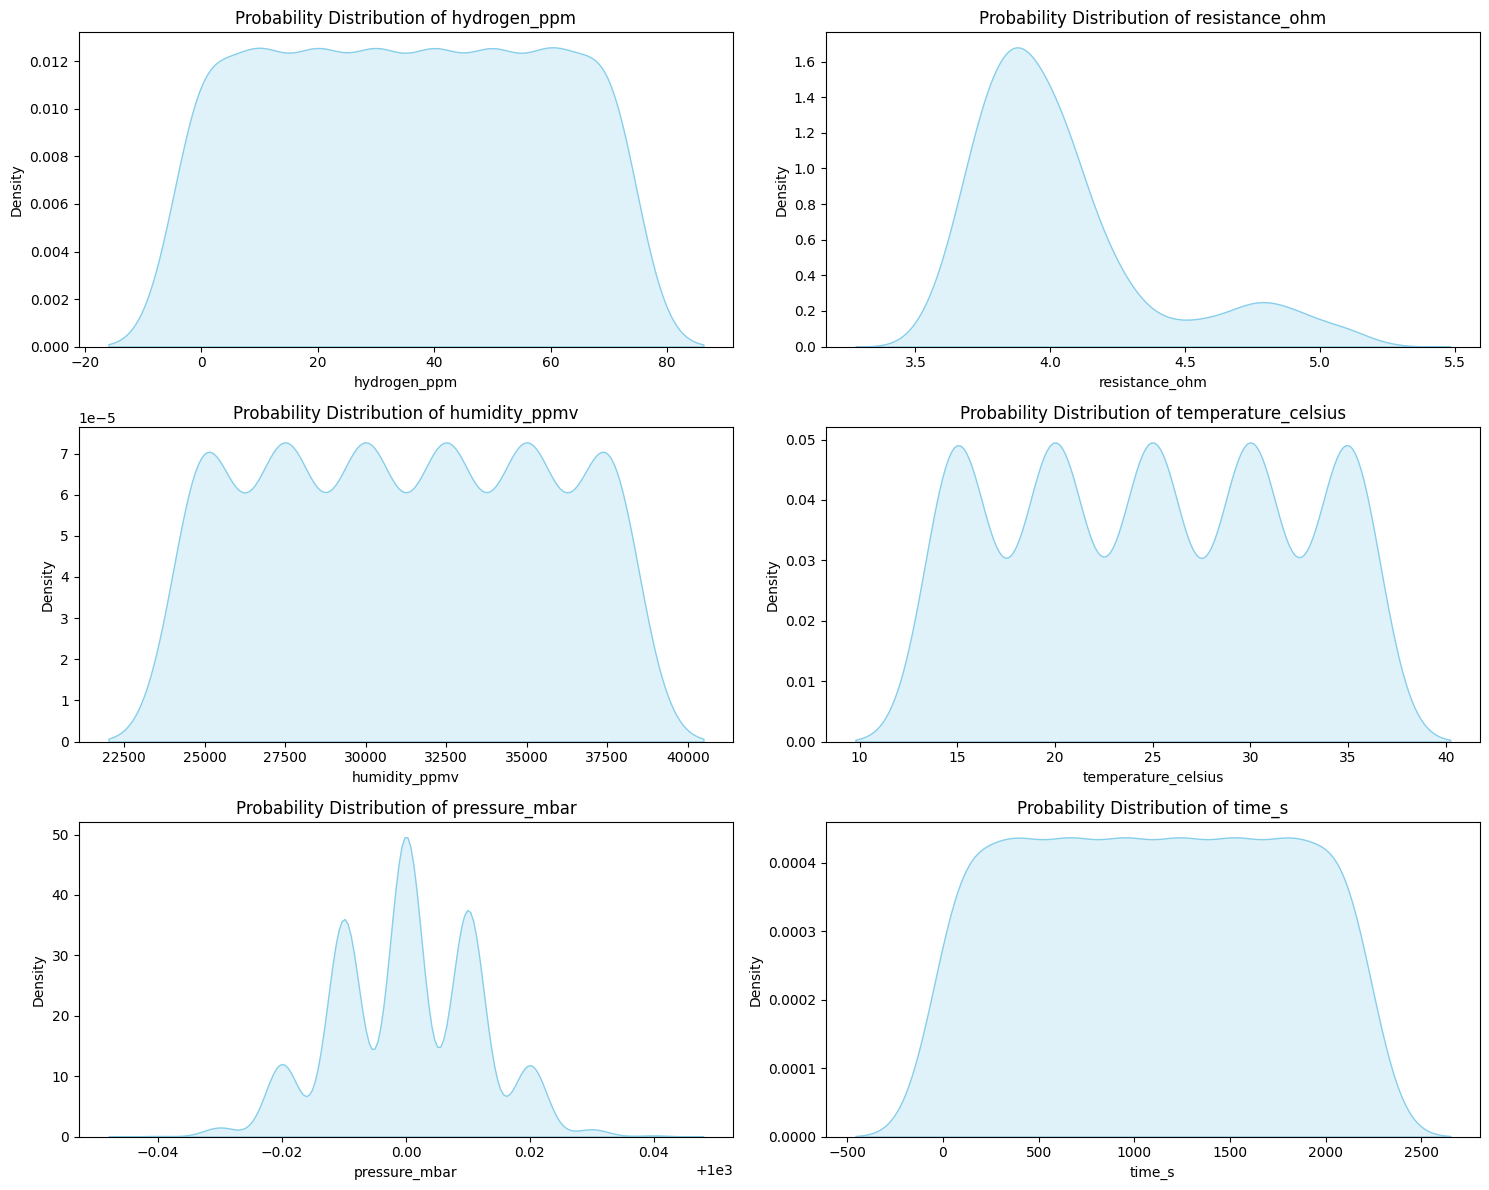

In [222]:
numerical_columns = [
    'hydrogen_ppm',
    'resistance_ohm',
    'humidity_ppmv',
    'temperature_celsius',
    'pressure_mbar',
    'time_s'
]
plt.figure(figsize=(15, 12))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(df[column], color='skyblue', fill=True)
    plt.title(f'Probability Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Correlation Analysis

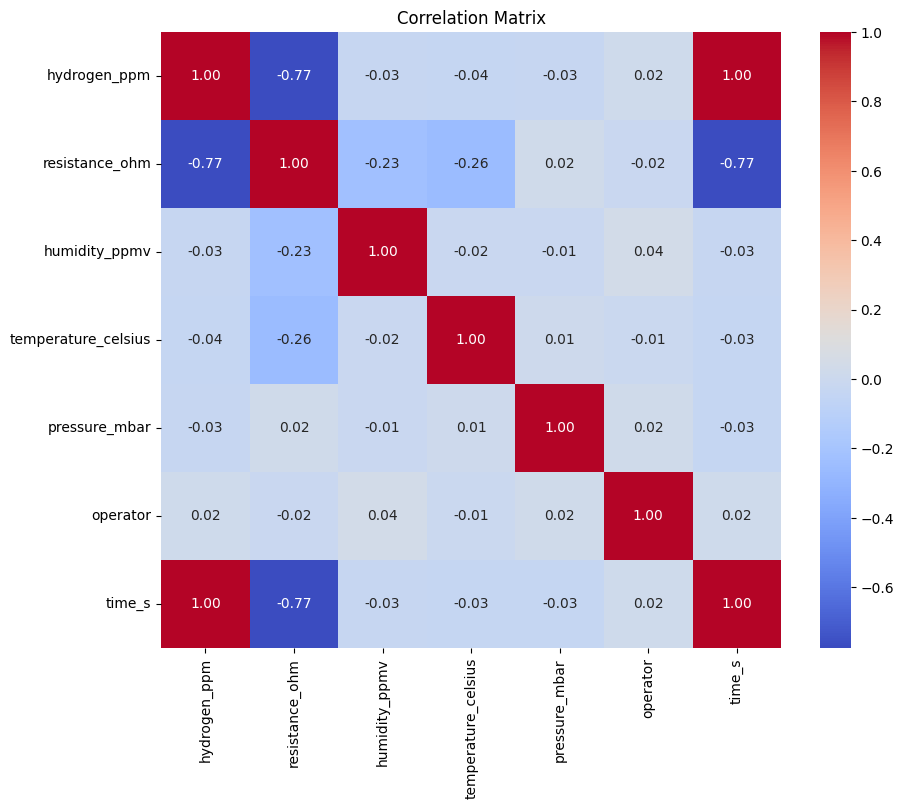

In [223]:
le = LabelEncoder()
df['operator'] = le.fit_transform(df['operator'])
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

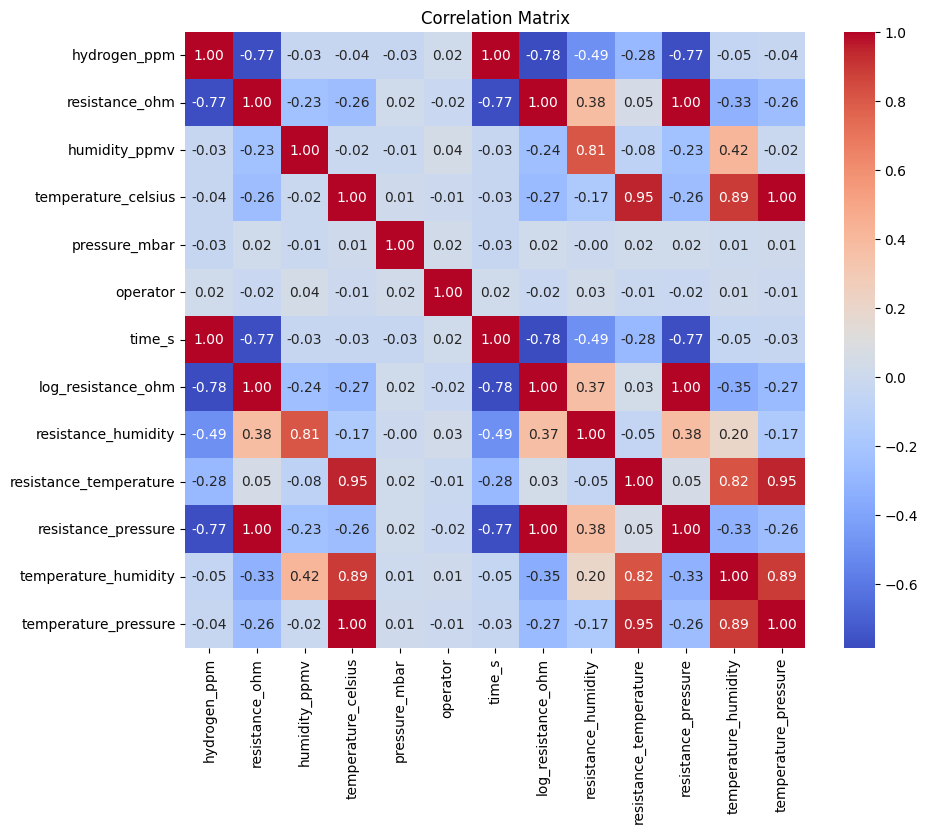

In [224]:

# Feature interaction
df['log_resistance_ohm'] = np.log(df['resistance_ohm'])
df['resistance_humidity'] = df['resistance_ohm'] * df['humidity_ppmv']
df['resistance_temperature'] = df['resistance_ohm'] * df['temperature_celsius']
df['resistance_pressure'] = df['resistance_ohm'] * df['pressure_mbar']
df['temperature_humidity'] = df['temperature_celsius'] * df['humidity_ppmv']
df['temperature_pressure'] = df['temperature_celsius'] * df['pressure_mbar']

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

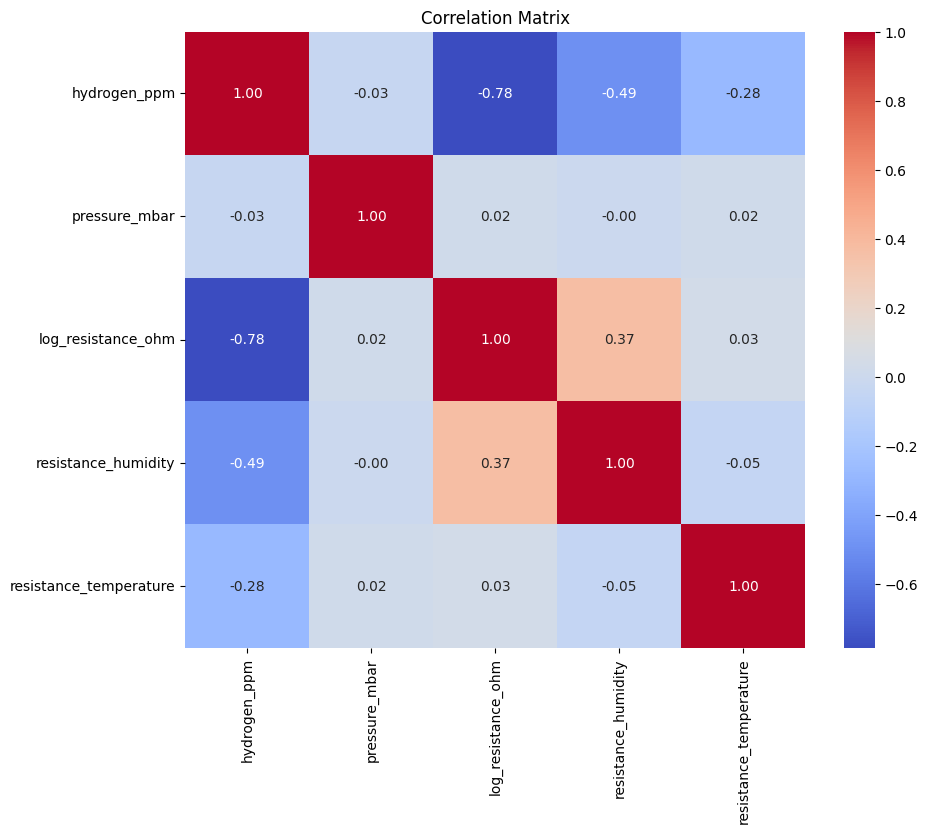

In [225]:

# Removing irrelevent attirbutes and the attributes with high multicolinearity
# 

# df.drop(
#     columns=[
#         'resistance_temperature','temperature_humidity',
#         'resistance_ohm',
#         'resistance_ohm','temperature_pressure',
#         'resistance_temperature','resistance_pressure','humidity_ppmv','time_s','operator'],inplace=True)

df.drop(
    columns=[
        #'resistance_temperature',
        'temperature_humidity','temperature_celsius',
        'resistance_ohm','temperature_pressure',
        'resistance_pressure','humidity_ppmv','time_s','operator'],inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Machine Learning

In [226]:
X = df.drop(columns=['hydrogen_ppm'])
y = df['hydrogen_ppm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest

In [227]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Performance:")
print(f"MAE: {mae_rf}\nR2: {r2_rf}")


Random Forest Performance:
MAE: 1.218191807407409
R2: 0.9922650865045576


In [228]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validation MAE (Random Forest):", np.mean(-rf_cv_scores))


Cross-validation MAE (Random Forest): 1.395950746031747


In [229]:
joblib.dump(rf_model,'model/rf_model_pred_hydrogen_concentration.joblib')

['model/rf_model_pred_hydrogen_concentration.joblib']